In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [25]:
import yfinance as yf

ticker = "GBPUSD=X"
start_date = "2005-01-01"
end_date = "2025-08-18"

print(f"Fetching data for {ticker}...")
data = yf.download(ticker, start=start_date, end=end_date)

# Select only the 'Close' column
df = data[['Close']]

# The rename line is now removed
# df.rename(columns={'Close': 'Price'}, inplace=True)

filename = 'gbpusd_20y.csv'
df.to_csv(filename)

print(f"Data saved successfully to {filename} with 'Close' column.")

#need to manually edit the csv file to remove the first row of names

Fetching data for GBPUSD=X...


/var/folders/m6/mgjfjp2s2b97v0p3wmv8x69m0000gn/T/ipykernel_52859/3990127909.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data saved successfully to gbpusd_20y.csv with 'Close' column.


In [26]:
df = pd.read_csv('gbpusd_20y.csv', parse_dates=True, index_col=0)
df = df[['Close']]

In [27]:
df.head()

,Close
Price,
2005-01-03,1.904617
2005-01-04,1.883594
2005-01-05,1.885512
2005-01-06,1.876490
2005-01-07,1.871293


In [37]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# 创建序列数据
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back):
        X.append(data[i:i+look_back, 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

look_back = 60
X, y = create_dataset(scaled_data, look_back)

# 划分训练集与测试集（80%训练，20%测试）
split = int(len(X)*0.7)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 转换为LSTM需要的格式 [样本数, 时间步数, 特征数]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))

In [38]:
model = Sequential()
model.add(LSTM(20, activation='relu', input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/Users/snowyan/gbptousd/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 20)             │         1,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,781 (6.96 KB)

 Trainable params: 1,781 (6.96 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1243 - val_loss: 0.0053
Epoch 2/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 3/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 5.8807e-04 - val_loss: 6.3516e-04
Epoch 4/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 3.9532e-04 - val_loss: 3.4551e-04
Epoch 5/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6849e-04 - val_loss: 2.3788e-04
Epoch 6/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4272e-04 - val_loss: 2.7508e-04
Epoch 7/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3336e-04 - val_loss: 2.3033e-04
Epoch 8/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2584e-04 - val_loss: 2.1724e-04
Epoch 9/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.0124e-04 - val_loss: 1.9035e-04
Epoch 10/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.9179e-04 - val_loss: 1.7669e-04
Epoch 11/20
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.8

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test RMSE: 0.012493689872395627


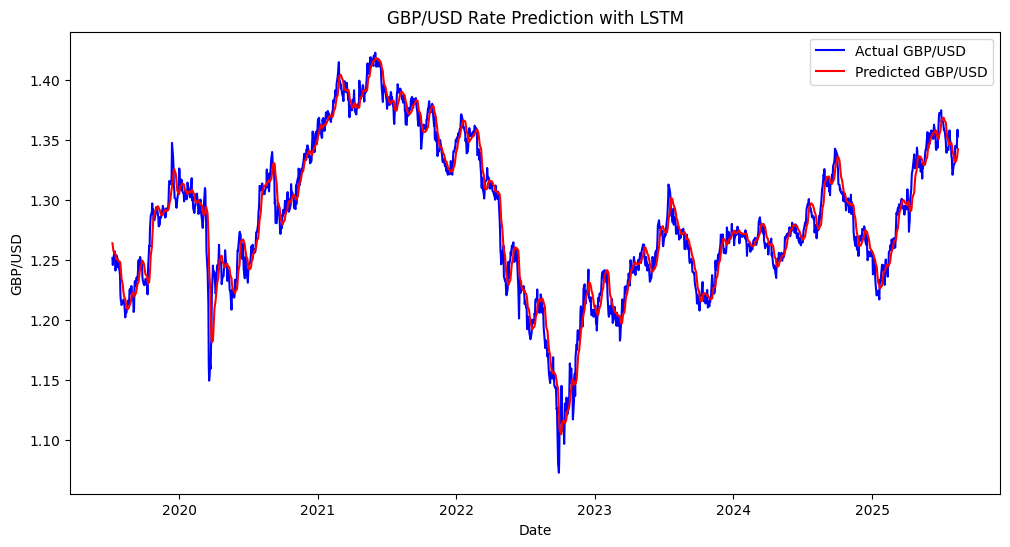

In [40]:
# 预测
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

# 评估误差
mse = mean_squared_error(y_test_real, predicted)
rmse = np.sqrt(mse)
print('Test RMSE:', rmse)

# 可视化
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test):], y_test_real, label='Actual GBP/USD', color='blue')
plt.plot(df.index[-len(predicted):], predicted, label='Predicted GBP/USD', color='red')
plt.xlabel('Date')
plt.ylabel('GBP/USD')
plt.title('GBP/USD Rate Prediction with LSTM')
plt.legend()
plt.show()

In [41]:
# 假设你已有训练好的模型 model 和 scaler，以及历史数据 df

# 先取出最近look_back天的数据作为输入
last_sequence = scaled_data[-look_back:]  # scaled_data 为前面的归一化后的数据
future_predictions = []

# 循环预测3天
n_future = 3

current_seq = last_sequence.reshape(1, look_back, 1)

for _ in range(n_future):
    # 预测下一个值
    next_pred = model.predict(current_seq)[0, 0]

    # 保存预测值
    future_predictions.append(next_pred)

    # 更新序列，删除第一个元素并加入新的预测
    current_seq = np.append(current_seq[:, 1:, :], [[[next_pred]]], axis=1)

# 将预测值逆归一化为真实汇率值
future_predictions_real = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# 创建预测日期索引
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future, freq='B')  # 使用工作日 (Business Day)

# 生成预测DataFrame
df_future = pd.DataFrame(data=future_predictions_real, index=future_dates, columns=['Predicted_Close'])
print(df_future)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
            Predicted_Close
2025-08-18         1.345076
2025-08-19         1.346281
2025-08-20         1.347301


/Users/snowyan/gbptousd/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27719 (\N{CJK UNIFIED IDEOGRAPH-6C47}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/snowyan/gbptousd/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/snowyan/gbptousd/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26410 (\N{CJK UNIFIED IDEOGRAPH-672A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/snowyan/gbptousd/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26469 (\N{CJK UNIFIED IDEOGRAPH-6765}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/snowyan/gbptousd/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarni

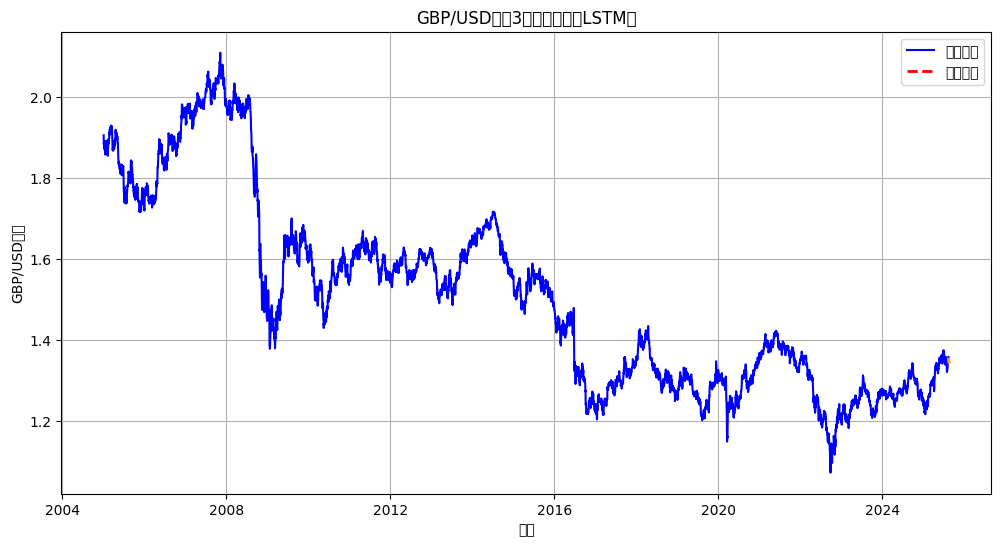

In [42]:
# 可视化历史数据和未来预测 - 修复版本
plt.figure(figsize=(12,6))

# 绘制历史数据
plt.plot(df.index, df['Close'], label='历史汇率', color='blue')

# 确保 future_predictions_real 是一维数组
future_predictions_flat = future_predictions_real.flatten()

# 绘制未来预测
plt.plot(future_dates, future_predictions_flat, label='未来预测', color='red', linewidth=2, linestyle='--')

# 连接历史数据和预测数据 - 修复版本
# 确保所有值都是标量
last_historical_date = df.index[-1]
last_historical_price = float(df['Close'].iloc[-1])
first_prediction_date = future_dates[0]
first_prediction_price = float(future_predictions_flat[0])

plt.plot([last_historical_date, first_prediction_date],
         [last_historical_price, first_prediction_price],
         color='orange', linewidth=2)

plt.xlabel('日期')
plt.ylabel('GBP/USD汇率')
plt.title('GBP/USD未来3天预测（使用LSTM）')
plt.legend()
plt.grid()
plt.show()


In [43]:
# 取最后look_back数据作为预测起点
current_seq = scaled_data[-look_back:].reshape((1, look_back, 1))
future_preds = []

for _ in range(3):
    pred = model.predict(current_seq)[0, 0]
    future_preds.append(pred)
    current_seq = np.append(current_seq[:,1:,:], [[[pred]]], axis=1)

# 逆归一化预测值
future_preds_real = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

# 创建未来预测的时间索引（1分钟间隔）
last_time = df.index[-1]
future_times = pd.date_range(last_time + pd.Timedelta(minutes=1), periods=3, freq='min')

# 输出未来预测结果
df_future = pd.DataFrame(data=future_preds_real, index=future_times, columns=['Predicted_Close'])
print(df_future)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
                     Predicted_Close
2025-08-15 00:01:00         1.345076
2025-08-15 00:02:00         1.346281
2025-08-15 00:03:00         1.347301
